In [1]:
import json, sys, random
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from PIL import Image, ImageDraw 

In [4]:
from matplotlib import pyplot as plt

### Download and study the dataset

In [5]:
# download dataset from json object
f = open(r'./input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(f)
f.close()

#dataset.head()

In [6]:
#df = np.array(dataset)
#df.head()

input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')
#path = "./input/ships-in-satellite-imagery/shipsnet.json"
#df = pd.read_json(path, lines=True)
#df.head(10)

#with open(path) as f:
#    data = pd.DataFrame(json.loads(line) for line in f)
#data.head(5)

INPUT

The dataset contains 4000 images. One image is represented as a vector of length 19200 elements.

In [29]:
input_data.shape
input_data[0,:]

array([82, 89, 91, ..., 86, 88, 89], dtype=uint8)

In [12]:
output_data.shape

(4000,)

In [17]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

(3, 80, 80)

In [35]:

# get one chanel
pic = X[2]

rad_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectum = pic[2]
X

array([[[[ 82,  89,  91, ...,  89,  84,  83],
         [ 89,  91,  89, ..., 101,  87,  87],
         [ 91,  93,  86, ...,  83,  90,  92],
         ...,
         [ 89,  88,  92, ...,  88,  85,  89],
         [ 87,  88,  91, ...,  91,  90,  90],
         [ 88,  91,  90, ...,  88,  89,  90]],

        [[ 94,  99, 101, ..., 102,  96,  96],
         [100, 102, 101, ..., 115, 100,  99],
         [101, 104,  98, ...,  96, 102, 102],
         ...,
         [ 98,  98, 102, ...,  99,  97, 100],
         [ 99,  99, 101, ..., 101, 101, 102],
         [ 99, 101, 101, ..., 101, 102, 102]],

        [[ 80,  86,  89, ...,  86,  81,  84],
         [ 86,  88,  89, ...,  97,  84,  86],
         [ 88,  92,  85, ...,  81,  88,  89],
         ...,
         [ 87,  86,  89, ...,  86,  84,  87],
         [ 87,  86,  88, ...,  88,  88,  89],
         [ 85,  87,  87, ...,  86,  88,  89]]],


       [[[ 76,  75,  67, ...,  78,  77,  80],
         [ 71,  73,  72, ...,  79,  77,  81],
         [ 73,  70,  67, ..., 

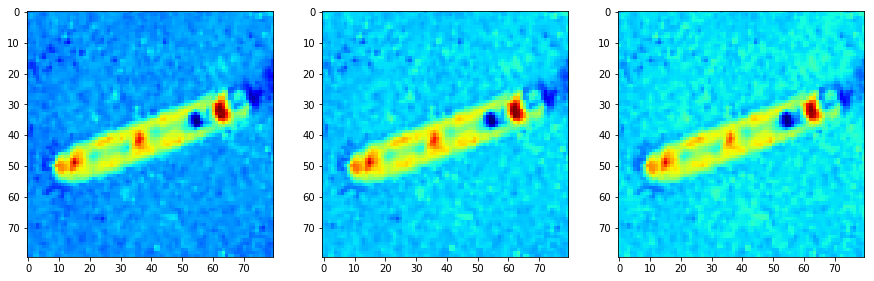

In [20]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# show each channel
plt.subplot(1, 3, 1)
plt.imshow(rad_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectum)
    
plt.show()

OUTPUT

The output is a vector of lenght 4000 elements.

In [22]:
output_data.shape

(4000,)

The vector contains int 0 and 1

In [26]:
#output_data
# https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-94.php
unique_elements, counts_elements = np.unique(output_data, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [3000 1000]]


Vector contains of 3000 zeros and 1000 units. This means that in a dataset of 1000 images tagged with "ship" and 3000 images marked as "not ship".

In [31]:
np.bincount(output_data)

array([3000, 1000])

### Preparing data

In [32]:
# output encoding
y = np_utils.to_categorical(output_data, 2)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [33]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

In [34]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]
X_train

array([[[[ 92,  93,  86],
         [ 86,  87,  79],
         [ 90,  90,  83],
         ...,
         [126, 126, 118],
         [131, 129, 120],
         [129, 127, 118]],

        [[ 91,  92,  85],
         [ 88,  88,  81],
         [ 93,  93,  85],
         ...,
         [124, 124, 116],
         [125, 124, 116],
         [124, 123, 114]],

        [[ 90,  91,  84],
         [ 91,  91,  84],
         [104, 103,  94],
         ...,
         [125, 124, 116],
         [125, 123, 115],
         [124, 122, 113]],

        ...,

        [[ 73,  75,  68],
         [ 82,  82,  76],
         [ 81,  81,  74],
         ...,
         [ 77,  79,  69],
         [ 82,  84,  74],
         [ 96,  97,  85]],

        [[ 75,  79,  72],
         [ 79,  81,  74],
         [ 82,  83,  75],
         ...,
         [ 89,  88,  78],
         [ 87,  88,  77],
         [ 93,  94,  82]],

        [[ 76,  81,  73],
         [ 77,  81,  73],
         [ 83,  85,  77],
         ...,
         [105, 102,  91],
        

In [17]:
# normalization
X_train = X_train / 255

### Traing network

In [18]:
np.random.seed(42)

In [19]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [20]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 2240 samples, validate on 560 samples
Epoch 1/18
 - 26s - loss: 0.3845 - acc: 0.8375 - val_loss: 0.1563 - val_acc: 0.9393
Epoch 2/18
 - 29s - loss: 0.1606 - acc: 0.9442 - val_loss: 0.0974 - val_acc: 0.9679
Epoch 3/18
 - 25s - loss: 0.1161 - acc: 0.9607 - val_loss: 0.0866 - val_acc: 0.9714
Epoch 4/18
 - 25s - loss: 0.1116 - acc: 0.9621 - val_loss: 0.0669 - val_acc: 0.9857
Epoch 5/18
 - 32s - loss: 0.0776 - acc: 0.9737 - val_loss: 0.0469 - val_acc: 0.9893
Epoch 6/18
 - 30s - loss: 0.0731 - acc: 0.9790 - val_loss: 0.0306 - val_acc: 0.9929
Epoch 7/18
 - 32s - loss: 0.0637 - acc: 0.9768 - val_loss: 0.0435 - val_acc: 0.9875
Epoch 8/18
 - 35s - loss: 0.0534 - acc: 0.9857 - val_loss: 0.0237 - val_acc: 0.9964
Epoch 9/18
 - 29s - loss: 0.0498 - acc: 0.9853 - val_loss: 0.0197 - val_acc: 0.9982
Epoch 10/18
 - 28s - loss: 0.0403 - acc: 0.9848 - val_loss: 0.0403 - val_acc: 0.9857
Epoch 11/18
 - 27s - loss: 0.0440 - acc: 0.9839 - val_loss: 0.0283 - val_acc: 0.9929
Epoch 12/18
 - 33s - loss: 

# Using network

### download image

In [36]:
image = Image.open('./input/sfbay/sfbay_4.png')
pix = image.load()

In [37]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]
print(width)
print(height)

2211
1007


In [38]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
            
picture_vector

[56,
 53,
 43,
 47,
 52,
 55,
 56,
 48,
 43,
 51,
 59,
 59,
 56,
 53,
 54,
 45,
 43,
 60,
 57,
 55,
 56,
 56,
 52,
 53,
 52,
 49,
 57,
 56,
 55,
 53,
 53,
 55,
 57,
 57,
 56,
 53,
 52,
 52,
 51,
 57,
 61,
 62,
 59,
 56,
 54,
 50,
 51,
 56,
 63,
 65,
 55,
 50,
 50,
 62,
 61,
 57,
 55,
 57,
 57,
 54,
 52,
 58,
 61,
 62,
 60,
 59,
 62,
 59,
 53,
 57,
 60,
 59,
 58,
 58,
 53,
 50,
 51,
 52,
 53,
 57,
 61,
 60,
 59,
 53,
 46,
 57,
 58,
 57,
 57,
 55,
 59,
 59,
 56,
 57,
 53,
 51,
 56,
 53,
 55,
 58,
 59,
 56,
 57,
 55,
 52,
 55,
 57,
 56,
 55,
 55,
 56,
 57,
 57,
 52,
 58,
 60,
 55,
 53,
 56,
 55,
 54,
 61,
 62,
 55,
 47,
 55,
 58,
 57,
 58,
 56,
 54,
 55,
 60,
 54,
 57,
 58,
 54,
 52,
 54,
 55,
 55,
 61,
 62,
 60,
 57,
 57,
 56,
 55,
 57,
 55,
 54,
 54,
 57,
 57,
 56,
 57,
 56,
 56,
 55,
 55,
 55,
 53,
 55,
 57,
 56,
 62,
 60,
 53,
 51,
 52,
 55,
 56,
 46,
 52,
 54,
 52,
 54,
 54,
 55,
 58,
 57,
 54,
 54,
 58,
 55,
 52,
 55,
 59,
 55,
 59,
 62,
 55,
 46,
 51,
 53,
 51,
 54,
 53,
 55,
 61,


In [40]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_vector


array([56, 53, 43, ..., 73, 72, 73], dtype=uint8)

In [41]:
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
picture_tensor

array([[[ 56,  70,  57],
        [ 53,  66,  55],
        [ 43,  57,  47],
        ...,
        [255, 242, 223],
        [255, 237, 217],
        [241, 223, 198]],

       [[ 52,  65,  53],
        [ 49,  62,  50],
        [ 46,  61,  51],
        ...,
        [255, 245, 236],
        [255, 244, 227],
        [255, 243, 226]],

       [[ 55,  68,  56],
        [ 51,  65,  54],
        [ 50,  65,  55],
        ...,
        [255, 245, 234],
        [255, 244, 229],
        [255, 244, 232]],

       ...,

       [[ 12,   9,   4],
        [ 51,  42,  31],
        [ 78,  71,  57],
        ...,
        [ 76,  81,  65],
        [ 77,  81,  67],
        [ 74,  80,  65]],

       [[ 41,  36,  26],
        [107,  95,  78],
        [183, 164, 145],
        ...,
        [ 78,  83,  67],
        [ 78,  82,  69],
        [ 81,  85,  71]],

       [[127, 110,  93],
        [190, 169, 149],
        [224, 204, 188],
        ...,
        [ 84,  89,  73],
        [ 82,  87,  72],
        [ 83,  88,  73]]

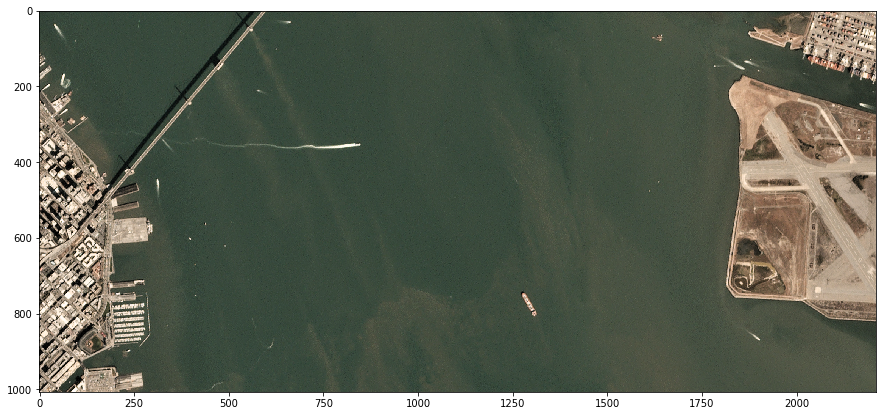

In [42]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

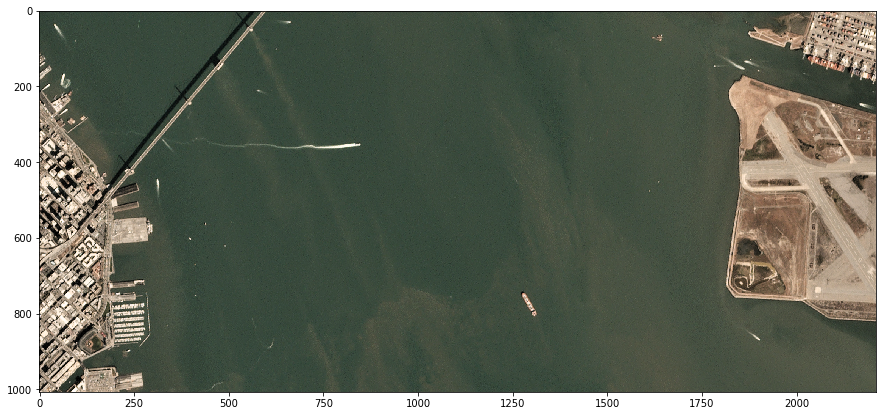

In [45]:
picture_tensor = picture_tensor.transpose(2,0,1)
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

### Search on the image

In [45]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [46]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [47]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:520 Y:0  [[0.02381977 0.97618026]]


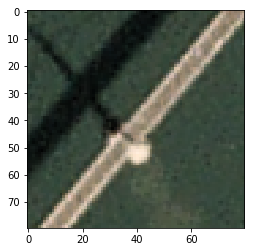

X:10 Y:10  [[0.05765004 0.94235   ]]


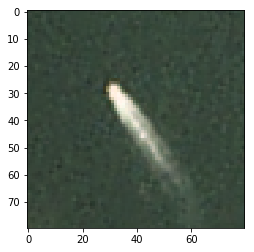

X:1860 Y:20  [[0.02872266 0.97127736]]


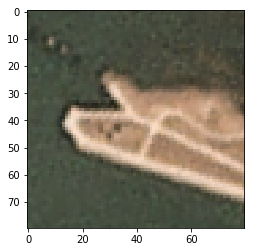

X:450 Y:90  [[0.00176652 0.99823344]]


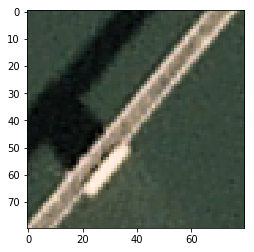

X:30 Y:150  [[0.01438344 0.98561656]]


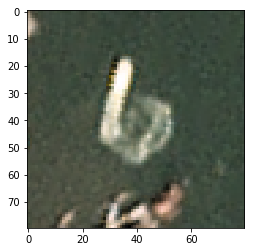

X:370 Y:180  [[0.00431016 0.9956898 ]]


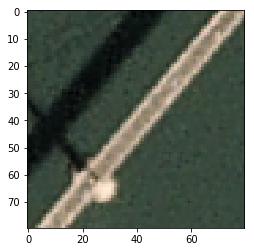

X:60 Y:250  [[0.05792868 0.9420713 ]]


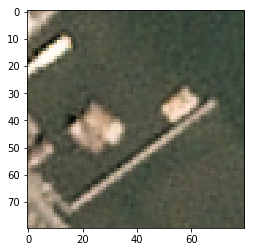

X:290 Y:270  [[0.05860606 0.941394  ]]


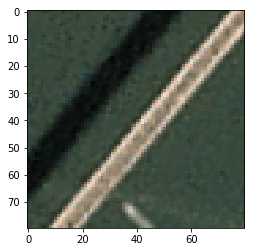

X:780 Y:310  [[0.06446259 0.93553746]]


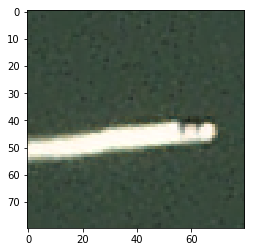

X:650 Y:320  [[0.06163143 0.9383686 ]]


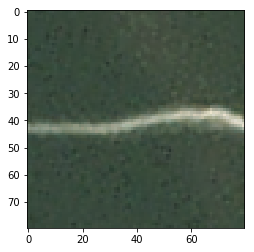

X:220 Y:360  [[0.00384741 0.9961526 ]]


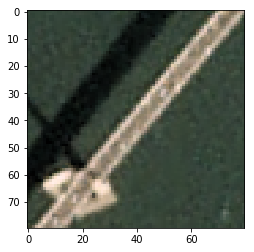

X:1810 Y:500  [[0.07600496 0.923995  ]]


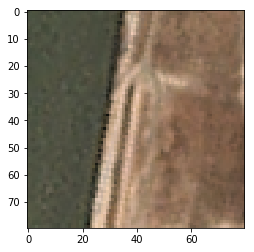

X:1790 Y:600  [[0.02333042 0.97666955]]


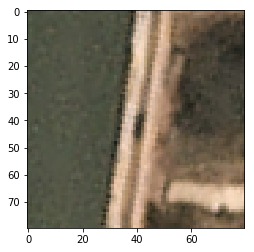

X:1790 Y:690  [[0.03213225 0.9678678 ]]


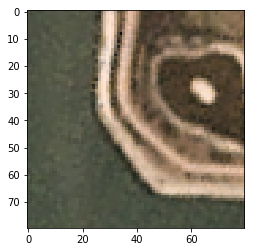

X:1880 Y:710  [[0.07347982 0.92652017]]


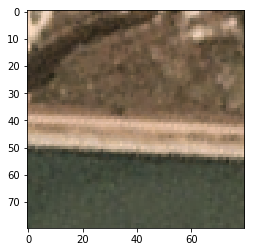

X:1250 Y:730  [[2.6600435e-05 9.9997342e-01]]


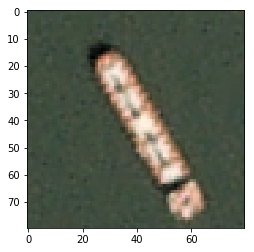

X:2130 Y:920  

In [48]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [52]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

IndexError: index 520 is out of bounds for axis 0 with size 3

In [53]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(2211, 3, 1007)

TypeError: Invalid dimensions for image data

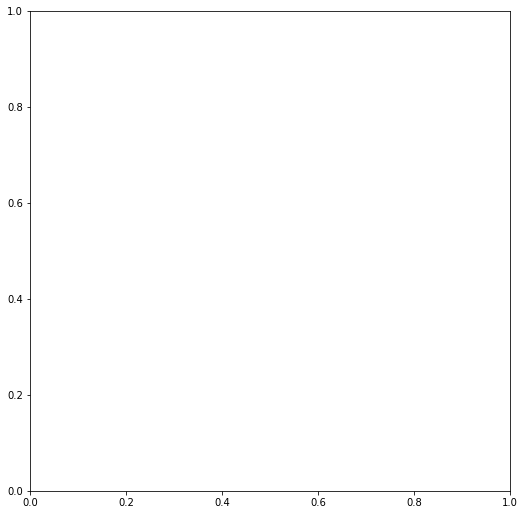

In [54]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()